In [91]:
import pathlib

import yaml

import numpy as np

import itertools

In [92]:
from pixell import enmap, utils as putils

In [10]:
import utilities as u

In [11]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'cmss10'}
font = font_manager.FontProperties(family='Latin Modern Roman',
                                   style='normal', size = 8)


In [12]:
import best
import re

In [13]:
values_file = 'configurations/configILC_plotting_profile.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [178]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [179]:
estimators

['hu_ok', 'shear', 'bh', 'pbh', 'symm', 'symmbh']

In [203]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [204]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [205]:
noisebiasconstr = False

In [206]:
get_dir = lambda h, s, b, p, sy, sybh: f'h{h}s{s}b{b}p{p}sy{sy}sybh{sybh}'

In [207]:
l = 3500

In [208]:
kk = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'kk_ilc.npy')
theta = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'theta_ilc.npy')
ells = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l, l, l)/'ells_ilc.npy')
selection = (ells > 30) & (ells < 1200)

In [209]:
resultspath = pathlib.Path(results_directory)

In [210]:
paperplots = pathlib.Path('paperplots/')

In [211]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [212]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [213]:
fb = 1.
invvariance = False
noisebiasconstr = False

In [214]:
analysis_directory_ref = 'output_ILC_1102'

In [215]:
reference_directory = pathlib.Path(analysis_directory_ref)/'h4000s4000b4000p4000sypbh4000sybh4000/total/'

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy', 'sybh']
Optimizerkk = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
#x_estimator = get_est_weights(Optimizerkk, index = 0)
#f, n, b = fnb_getter(Optimizerkk, fb, True)
#f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)

In [216]:
reference_directory

PosixPath('output_ILC_1102/h4000s4000b4000p4000sypbh4000sybh4000/total')

In [217]:
Nells = len(ells)

In [218]:
estimators_reference = ['h', 'b']
Nests = len(estimators_reference)
newBias = np.zeros((Nests, Nests, Nells))
newBias[0, 0, :] = biases[0, 0]
newBias[0, 0, 4] = 0. #NOTA!!
newBias[0, 1, :] = biases[0, 2]
newBias[1, 0, :] = biases[2, 0]
newBias[1, 1, :] = biases[2, 2]

newNoise = np.zeros((Nests, Nests, Nells))
newNoise[0, 0, :] = noises[0, 0]
newNoise[0, 1, :] = noises[0, 2]
newNoise[1, 0, :] = noises[2, 0]
newNoise[1, 1, :] = noises[2, 2]

newTheta = u.getcovarianceauto(newNoise, kk, fsky = 1.)

In [219]:
lmax_sel = 1200

In [220]:
import numpy as np

import mystic.solvers as my
from mystic.coupler import and_, or_, not_
from mystic.constraints import and_ as _and, or_ as _or, not_ as _not

from mystic.monitors import VerboseMonitor

from mystic.penalty import linear_equality, quadratic_equality
from mystic.constraints import as_constraint

from mystic.strategy import Best1Bin, Rand1Bin

import pathlib

class Opt():
    def __init__(self, estimators, lmin_sel, lmax_sel, ells, theory, theta, biases, noises, estimators_to_ignore = None, biases_errors = None):

        self.ells = ells
        self.theta = theta
        self.biases = biases
        self.noises = noises
        self.theory = theory
        self.biases_errors = biases_errors
        #TEMPORARY FOR NOW
        if estimators_to_ignore is not None:
            index = estimators.index(estimators_to_ignore)+1
            self.theta = self.theta[index:, index:, index:, index:, ...]
            self.biases = self.biases[index:, index:, ...]
            self.noises = self.noises[index:, index:, ...]
            estimators = estimators[index:]
            
        
        self.estimators = estimators
        self.lenestimators = len(estimators)

        self.lmin_sel = lmin_sel
        self.lmax_sel = lmax_sel

        self._select()

    def _select(self):
        selected = (self.ells > self.lmin_sel) & (self.ells < self.lmax_sel)
        self.ells_selected = self.ells[selected]

        self.theta_selected = self.theta[..., selected]
        self.biases_selected = self.biases[..., selected]
        self.noises_selected = self.noises[..., selected]

        if self.biases_errors is not None:
            self.biases_errors_selected = self.biases_errors[..., selected] 
        else:
            self.biases_errors_selected = None

        self.theory_selected = self.theory[selected]
        self.nbins = len(self.ells_selected)


    def _get_combined(self, ells, weights_per_l, total, theory):
        z = weights_per_l*total/theory
        biasterm = self.integerate_discrete(z, ells)
        return biasterm


    def get_mv_weights(self, ells, theory, variance):
        weights = theory**2/variance
        norm = self.integerate_discrete(weights, ells)
        weights = weights/norm
        return weights


    def get_variance_part(self, a, theta):
        if theta.ndim > 3:
            #this is for auto
            variance_part = np.einsum('...i, ...j, ...k, ...m , ijkm...->...', a, a, a, a, theta)
        else:
            variance_part = np.einsum('...i, ...j, ij...->...', a, a, theta)
        return variance_part

    def get_final_variance_weights(self, x, ells, theory, theta, inv_variance):
        a = self.get_a(x, inv_variance)
        variance = self.get_variance_part(a, theta)
        return self.get_weight_per_l(x, ells, theory, variance, inv_variance)

    def get_bias_part(self, a, bias):
        if bias.ndim > 2:
            #this is for auto
            bias_part = np.einsum('...i, ...j, ij...->...', a, a, bias)
        else:
            bias_part = np.einsum('...i, i...->...', a, bias)
        return bias_part

    def get_per_l_part(self, a, matrix):
        if matrix.ndim > 2:
            #this is for auto
            part = np.einsum('...i, ...j, ij...->...', a, a, matrix)
        return part


    def get_bias_term(self, ells, theory, bias, a, weight_per_l):
        bias_part = self.get_bias_part(a, bias)
        biasterm = self._get_combined(ells, weight_per_l, bias_part, theory)
        return biasterm


    def get_a(self, x, inv_variance):
        a = x[:-self.nbins].reshape(self.nbins, self.lenestimators) if not inv_variance else x.reshape(self.nbins, self.lenestimators)
        return a

    def get_weight_per_l(self, x, ells, theory, variance_part, inv_variance):
        if inv_variance:
            weight_per_l = self.get_mv_weights(ells, theory, variance_part)
        else:
            weight_per_l = x[-self.nbins:]
        return weight_per_l

    def get_f_n_b(self, ells, theory, theta, bias, sum_biases_squared = False, bias_squared = False, fb = 1., inv_variance = False, noiseparameter = 1.):
        
        def f(x):
            a = self.get_a(x, inv_variance)
            variance_part = self.get_variance_part(a, theta)

            weight_per_l = self.get_weight_per_l(x, ells, theory, variance_part, inv_variance)

            total_result = 0.

            biasterm = self.get_bias_term(ells, theory, bias, a, weight_per_l)**2.
            squarednoiseterm = self._get_combined(ells, weight_per_l**2., variance_part, theory**2.) 

            total_result = noiseparameter*squarednoiseterm+biasterm*fb

            return total_result


        def noisef(x):
            a = self.get_a(x, inv_variance)
            variance_part = self.get_variance_part(a, theta)
            weight_per_l = self.get_weight_per_l(x, ells, theory, variance_part, inv_variance)
            squarednoiseterm = self._get_combined(ells, weight_per_l**2., variance_part, theory**2.)
            noiseterm = np.sqrt(squarednoiseterm)
            return noiseterm

        def biasf(x):
            a = self.get_a(x, inv_variance)
            variance_part = self.get_variance_part(a, theta)
            weight_per_l = self.get_weight_per_l(x, ells, theory, variance_part, inv_variance)
            biasterm = self.get_bias_term(ells, theory, bias, a, weight_per_l)
            return biasterm

        return f, noisef, biasf

    def integerate_discrete(self, y, ells):
        #Nmodes = lEdges[1:]**2. - lEdges[:-1]**2
        factor = 4*np.pi
        return np.trapz(y*ells, ells)*(2*np.pi)/(2*np.pi)**2*factor
       

    def optimize(self, optversion, method = 'diff-ev', gtol = 5000, positive_weights: bool = True, x0 = None, bs0 = None, bounds = [0., 1.], noisebiasconstr = False, fb = 1., inv_variance = False, verbose = True, noiseparameter = 1., regularise = False, threshold = 0.001, regtype = 'std', 
                 scale = 0.8, cross = 0.9, npopfactor = 1., strategy = 'Best1Bin', ftol = 1e-12):
        '''
        Methods: diff-ev, SLSQP
        '''
        
        if strategy == 'Best1Bin':
            strategy = Best1Bin
        elif strategy == 'Rand1Bin':
            strategy = Rand1Bin
        else:
            strategy = None
        
        if verbose:
            print(f'Start optimization with {method}')

            if inv_variance:
                print('Using combined inverse variance weights')

        if x0 is None:
            x0 = []
            if self.lenestimators == 2:
                v = np.random.rand(1)/2
            elif self.lenestimators == 3:
                v = np.random.rand(2)/3
            elif self.lenestimators == 4:
                v = np.random.rand(3)/4
            for a in v:
                x0 += [a]
            x0 += [1.-np.sum(v)]
            x0 = np.array(x0*int(self.nbins))

        if bs0 is None:
            bs0 = np.ones(int(self.nbins))
            norma = self.integerate_discrete(bs0, self.ells_selected)
            bs0 /= norma
        
        dims = (self.lenestimators+1) if not inv_variance else self.lenestimators
        bnds = [(bounds[0], bounds[1]) for i in range(dims*self.nbins)]
        bnds = tuple(bnds)

        if inv_variance:
            x0 = x0
        else:
            x0 = np.append(x0, bs0)

        #if positive_weights:
        #    cons = ({'type': 'eq', 'fun': self.get_constraint()}, {'type': 'ineq', 'fun': self.get_constraint_ineq()})
        #else:
        #    cons = ({'type': 'eq', 'fun': self.get_constraint()})


        weights_name = optversion['weights_name']

        if verbose:
            print(f'Doing for {weights_name}')

        sum_biases_squared = optversion['sum_biases_squared']
        abs_biases = optversion['abs_biases']
        bias_squared = optversion['bias_squared']

        if abs_biases:
            prepare = lambda x: abs(x)
        else:
            prepare = lambda x: x

        f, noisef, biasf = self.get_f_n_b(self.ells_selected, self.theory_selected, self.theta_selected, prepare(self.biases_selected), sum_biases_squared = sum_biases_squared, bias_squared = bias_squared, fb = fb, inv_variance = inv_variance, noiseparameter = noiseparameter)
        self.f = f
        self.noisef = noisef
        self.biasf = biasf

        _, _, biasf_with_sign = self.get_f_n_b(self.ells_selected, self.theory_selected, self.theta_selected, self.biases_selected, sum_biases_squared = sum_biases_squared, bias_squared = bias_squared, fb = fb, inv_variance = inv_variance, noiseparameter = noiseparameter)
        extra_constraint = lambda x: abs(self.noisef(np.array(x))-abs(biasf_with_sign(np.array(x))))

        if self.biases_errors_selected is not None:
            _, _, biasf_error = self.get_f_n_b(self.ells_selected, self.theory_selected, self.theta_selected, self.biases_errors_selected, sum_biases_squared = sum_biases_squared, bias_squared = bias_squared, fb = fb, inv_variance = inv_variance, noiseparameter = noiseparameter)

        def constraint_eq(x):
            x = np.array(x)
            a = self.get_a(x, inv_variance)
            a[:, -1] = 1-np.sum(a[:, :-1], axis = 1)
            if not inv_variance:
                x[:-self.nbins] = a.flatten()
            else:
                x = a.flatten()
            return x

        def penalty1(x):
            x = np.array(x)
            b = x[-self.nbins:]
            res = self.integerate_discrete(b, self.ells_selected)
            return 1-res


        def get_reg(biases, theorykk, threshold = 0.001, regtype = 'std', lambda_value = 1e-12):
            '''
            regtype: std, extra, biaserror
            '''
            relative = biases/theorykk
            Ne = biases.shape[0]
            
            def loop_over(v):
                selection = np.zeros_like(v, dtype = bool)
                result = 0.
                for i, vx in enumerate(v):
                    selectiontemp = selection
                    selectiontemp[i] = True
                    result += np.sum((1-~selectiontemp*v)**2.)*vx**2.
                return result

            def regel(ai, selection, regtype):
                if regtype == 'std':
                    return np.sum(ai**2*selection)
                elif regtype == 'extra':
                    return regel(ai, selection, regtype = 'std')+loop_over(ai)*lambda_value
            def reg_with_weights(x):
                x = np.array(x)
                a = self.get_a(x, inv_variance).T
                total = 0.
                for i in range(Ne):
                    selection = abs(relative[i, i]) < threshold
                    total += regel(a[i], selection, regtype)
                return total
            
            def regbias(x):
                return biasf_error(x)**2

            if regtype in ['std', 'extra']:
                reg = reg_with_weights
            else:
                reg = regbias
            
            return reg
        
        regulariser = get_reg(self.biases_selected, self.theory_selected, threshold, regtype)

    
        k = 1e20

        if noisebiasconstr:
            gtol = gtol
            @quadratic_equality(condition=penalty1, k = k)
            @quadratic_equality(condition=extra_constraint, k = k)
            def penalty(x):
                return 0.0
        else:
            gtol = gtol
            @quadratic_equality(condition=penalty1, k = k)
            def penalty(x):
                return 0.0       

        if inv_variance:
            penalty = None 
            if noisebiasconstr:
                @quadratic_equality(condition=extra_constraint, k = k)
                def penalty(x):
                    return 0.0

        mon = VerboseMonitor(100)
        
        f0 = f(np.array(x0))

        if regularise:
            print('Regularizing')
            func = lambda x: f(np.array(x))+regulariser(np.array(x)) 
        else:
            func = lambda x: f(np.array(x))
         
        print('LEN', len(list(bnds)))
        
        if method == 'diff-ev': 
            result = my.diffev(func, x0, npop = npopfactor*10*len(list(bnds)), bounds = bnds, ftol = ftol, gtol = gtol, maxiter = 1024**3, maxfun = 1024**3, 
                               constraints = constraint_eq, penalty = penalty, full_output = True, itermon = mon, scale = scale, cross = cross, strategy = strategy)
            #mon = VerboseMonitor(100)
            #result = my.fmin_powell(func, result[0], bounds = bnds, constraints = constraint_eq, penalty = penalty, full_output = True, gtol = 400, maxfun = 1024**3, maxiter = 1024**3, ftol = 1e-7, itermon = mon)
        elif method == 'buckshot':
            result = my.buckshot(lambda x: f(np.array(x)), len(x0), npts = 16, bounds = bnds, constraints = constraint_eq, penalty = penalty, full_output = True, itermon = mon)#, ftol = 1e-6, gtol = gtol, maxiter = 1024**3, maxfun = 1024**3, constraints = constraint_eq, penalty = penalty, full_output=True, itermon = mon)
        elif method == 'powell':
            result = my.fmin_powell(func, x0, bounds = bnds, constraints = constraint_eq, penalty = penalty, full_output = True, gtol = gtol, maxfun = 1024**3, maxiter = 1024**3, ftol = 1e-7, itermon = mon)
        else:
            print(f'{method} not implemented!')
        
        history = np.hstack((np.array(mon.x), np.array(mon.y)[:, None]))
        
        result = Res(result[0], self.ells_selected, history)
        self.result = result
         
        ws = self.get_weights(result.x, inv_variance, verbose = verbose)        
        weights_per_l = self.get_final_variance_weights(result.x, self.ells_selected, self.theory_selected, self.theta_selected, inv_variance)

        result.set_weights(tuple(list(ws)+[weights_per_l]))
        
        self.monitor = mon
        
        return result
       
    def get_weights(self, x, inv_variance, verbose = True):

        aa = self.get_a(x, inv_variance)
        if verbose:
            print('Weights in columns', aa)
            print('Sum', np.sum(aa, axis = 1))

        ns = aa.shape[1]
        lista = []
        for i in range(ns):
            lista += [aa[:, i]]
        ws = tuple(lista)
        return ws

 
class Res():
    def __init__(self, risultato = None, ells = None, history = None):
        self.x = risultato
        self.set_ells(ells)
        self.history = history
    
    def set_ells(self, ells):
        self.ells = ells
        if ells is not None:
            self.nbins = len(ells)

    def set_weights(self, ws):
        self.ws = ws

    def save(self, element, path, name):
        nome = name
        P = self._create_path(path)
        np.save(path/nome, element)

    def load(self, path, name):
        nome = name+'.npy'
        P = self._create_path(path)
        return np.load(path/nome)

    def save_x(self, path, name, xname = 'x_'):
        nome = xname+name
        np.save(path/nome, self.x)
    def save_weights(self, path, name, wname = 'w_'):
        nome = wname+name
        np.save(path/nome, np.c_[[self.ells]+list(self.ws)])
    def save_history(self, path, name, hname = 'h_'):
        nome = hname+name
        if self.history is not None:
            np.save(path/nome, self.history)
    def load_x(self, path, name, xname = 'x_'):
        nome = xname+name+'.npy'
        self.x = np.load(path/nome)
    def load_weights(self, path, name, wname = 'w_'):
        nome = wname+name+'.npy'
        f = np.load(path/nome).T
        self.set_ells(f[:, 0])
        self.ws = f[:, 1:]

    def _create_path(self, path):
        P = pathlib.Path(path)
        if not P.exists():
            P.mkdir(parents = True, exist_ok = True)
        return P
    def save_all(self, path, name):
        P = self._create_path(path)
        self.save_x(P, name)
        self.save_weights(path, name)
        self.save_history(path, name)

    def load_all(self, path, name):
        P = self._create_path(path)
        self.load_x(P, name)
        self.load_weights(path, name)
        self.wx = self.x[:-self.nbins]
    def plot(self, path, name):
        return 0

class ResultsPlotter():
    def __init__(self):
        return 0


In [221]:
Optimizerkk = Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, newTheta, newBias, newNoise)
Optimizerkk_ = Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, newTheta, newBias, newNoise, biases_errors = newBias*0.+0.01)


In [222]:
from scipy.ndimage import gaussian_filter1d

In [223]:
Optimizerkk.biases_selected.shape

(2, 2, 8)

In [240]:
for i in range(2):
    for j in range(2):
        b = abs(Optimizerkk.biases_selected[i, j])
        print(gaussian_filter1d(b, 1)/gaussian_filter1d(abs(Optimizerkk.biases_selected), 1)[i, j])
        #Optimizerkk.biases_selected[i, j] = gaussian_filter1d(b, 1)

[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [248]:
bin_edges = np.logspace(np.log10(10), np.log10(4000), 15, 10.)
(bin_edges[1:]+bin_edges[:-1])/2

array([  12.67063702,   19.43837149,   29.82093841,   45.74911884,
         70.18497695,  107.67269654,  165.18363449,  253.41274046,
        388.76742983,  596.41876813,  914.98237683, 1403.69953905,
       2153.45393072, 3303.67268974])

In [278]:
bin_edges

array([  10.        ,   15.34127405,   23.53546894,   36.10640788,
         55.39182981,   84.9781241 ,  130.36726897,  200.        ,
        306.82548093,  470.70937873,  722.12815753, 1107.83659612,
       1699.56248197, 2607.34537948, 4000.        ])

In [252]:
bin_edges_ = bin_edges[bin_edges>30]
bin_edges_ = bin_edges_[bin_edges_<1200]
(bin_edges_[1:]+bin_edges_[:-1])/2

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [249]:
el

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [253]:
deltas = bin_edges_[1:]-bin_edges_[:-1]
deltas

array([ 19.28542193,  29.58629429,  45.38914488,  69.63273103,
       106.82548093, 163.8838978 , 251.4187788 , 385.70843859])

In [277]:
el

array([ 45.74911884,  70.18497695, 107.67269654, 165.18363449,
       253.41274046, 388.76742983, 596.41876813, 914.98237683])

In [257]:
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

In [262]:
sigmas = fwhm2sigma(deltas)
sigmas

array([  8.18976464,  12.56414237,  19.27499512,  29.57029824,
        45.36460489,  69.59508356, 106.76772492, 163.79529273])

In [260]:
gaussian(b, sigmas)

array([0.08634031, 0.05627975, 0.03668519, 0.02391274, 0.01558719,
       0.0101603 , 0.00662285, 0.00431702])

In [265]:
gaussian(b, sigmas).shape

(8,)

In [266]:
np.trapz(gaussian(b, sigmas), ells)

12.197651976257582

In [254]:
def gaussian(x, sigma):
    return 1/np.sqrt(2*sigma**2)*np.exp(0.5*x**2/sigma**2)

In [273]:
def smooth(b, ells, deltas, par = 1.):
    sigmas = fwhm2sigma(deltas*par)
    smoothed_vals = np.zeros(b.shape)
    for i, pair in enumerate(zip(ells, sigmas)):
        x_position, sigma = pair
        kernel = np.exp(-(ells - x_position) ** 2 / (2 * sigma ** 2))
        kernel = kernel / sum(kernel)
        smoothed_vals[i] = sum(b * kernel)
    return smoothed_vals

In [ ]:
def filter_(self, x, sigma):
    #temporary
    bin_edges = np.logspace(np.log10(10), np.log10(4000), 15, 10.)
    bin_edges_ = bin_edges[bin_edges>self.lmin_sel]
    bin_edges_ = bin_edges_[bin_edges_<self.lmax_sel]
    deltas = bin_edges_[1:]-bin_edges_[:-1]

    return self.smooth(x, self.ells_selected, deltas, par = sigma)

def scipy_gaussian(self, x, sigma):
    return gaussian_filter1d(x, sigma)

def fwhm2sigma(self, fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

def smooth(self, b, ells, deltas, par = 1.):
    sigmas = self.fwhm2sigma(deltas*par)
    smoothed_vals = np.zeros(b.shape)
    Ne = b.shape[0]
    for m in range(Ne):
        for n in range(Ne):
            x = b[m, n]
            for i, pair in enumerate(zip(ells, sigmas)):
                x_position, sigma = pair
                kernel = np.exp(-(ells - x_position) ** 2 / (2 * sigma ** 2))
                kernel = kernel / sum(kernel)
                smoothed_vals[m, n, i] = sum(x * kernel)
    return smoothed_vals

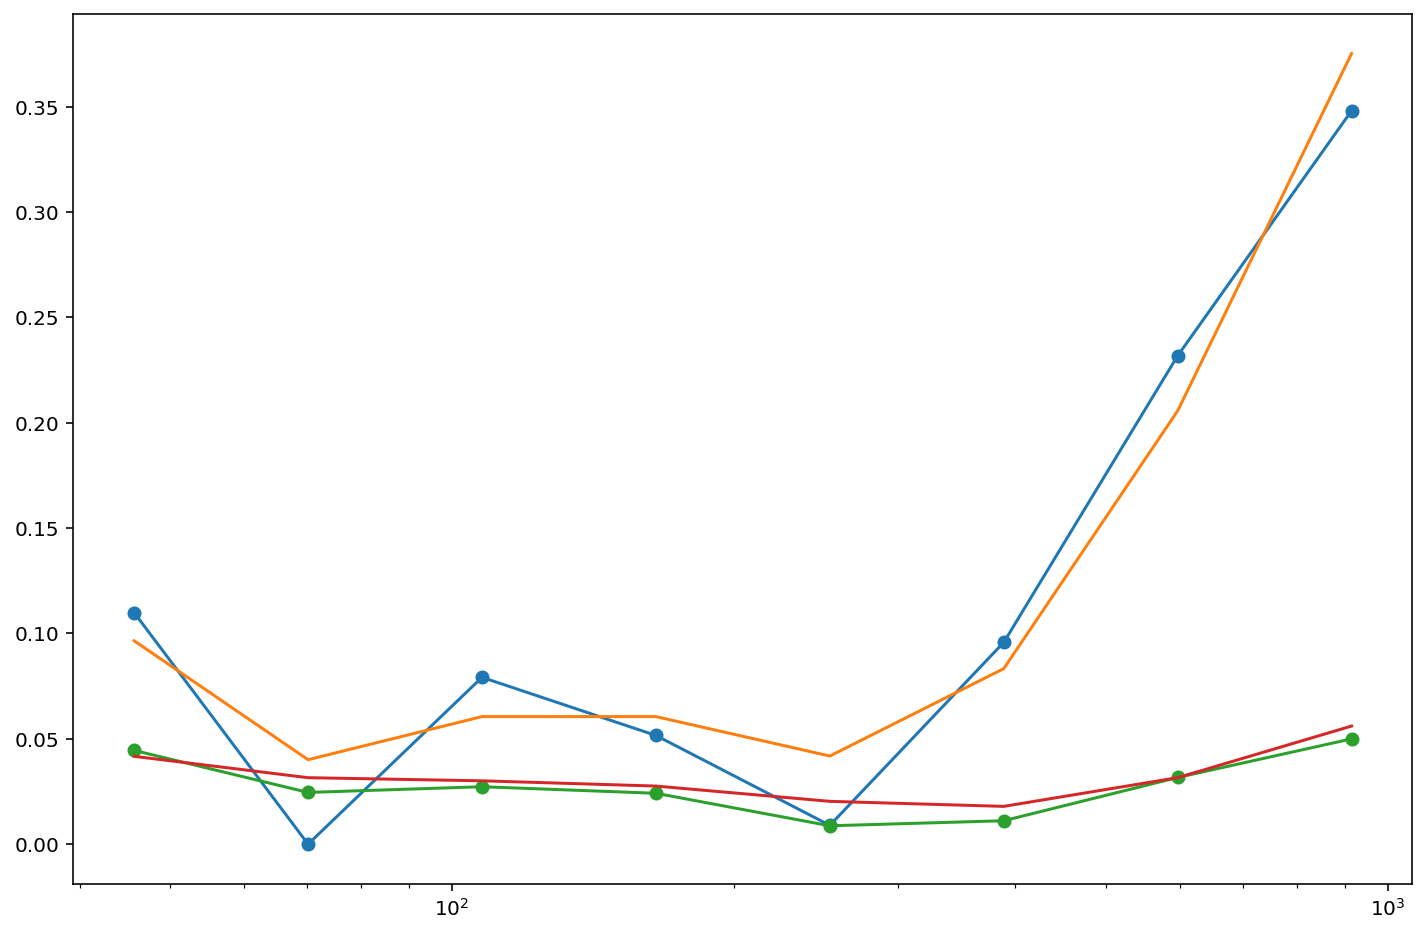

In [276]:
el = Optimizerkk.ells_selected
for i in range(2):
    b = abs(Optimizerkk.biases_selected[i, i])
    k = Optimizerkk.theory_selected
    
    p = plt.plot(el, b/k)

    b = abs(Optimizerkk.biases_selected[i, i])
    plt.plot(el, gaussian_filter1d(b, 0.05)/k, color = p[0].get_color(), marker = 'o', ls = '')
    plt.plot(el, smooth(b, ells, deltas, 1.5)/k)
    
plt.xscale('log')

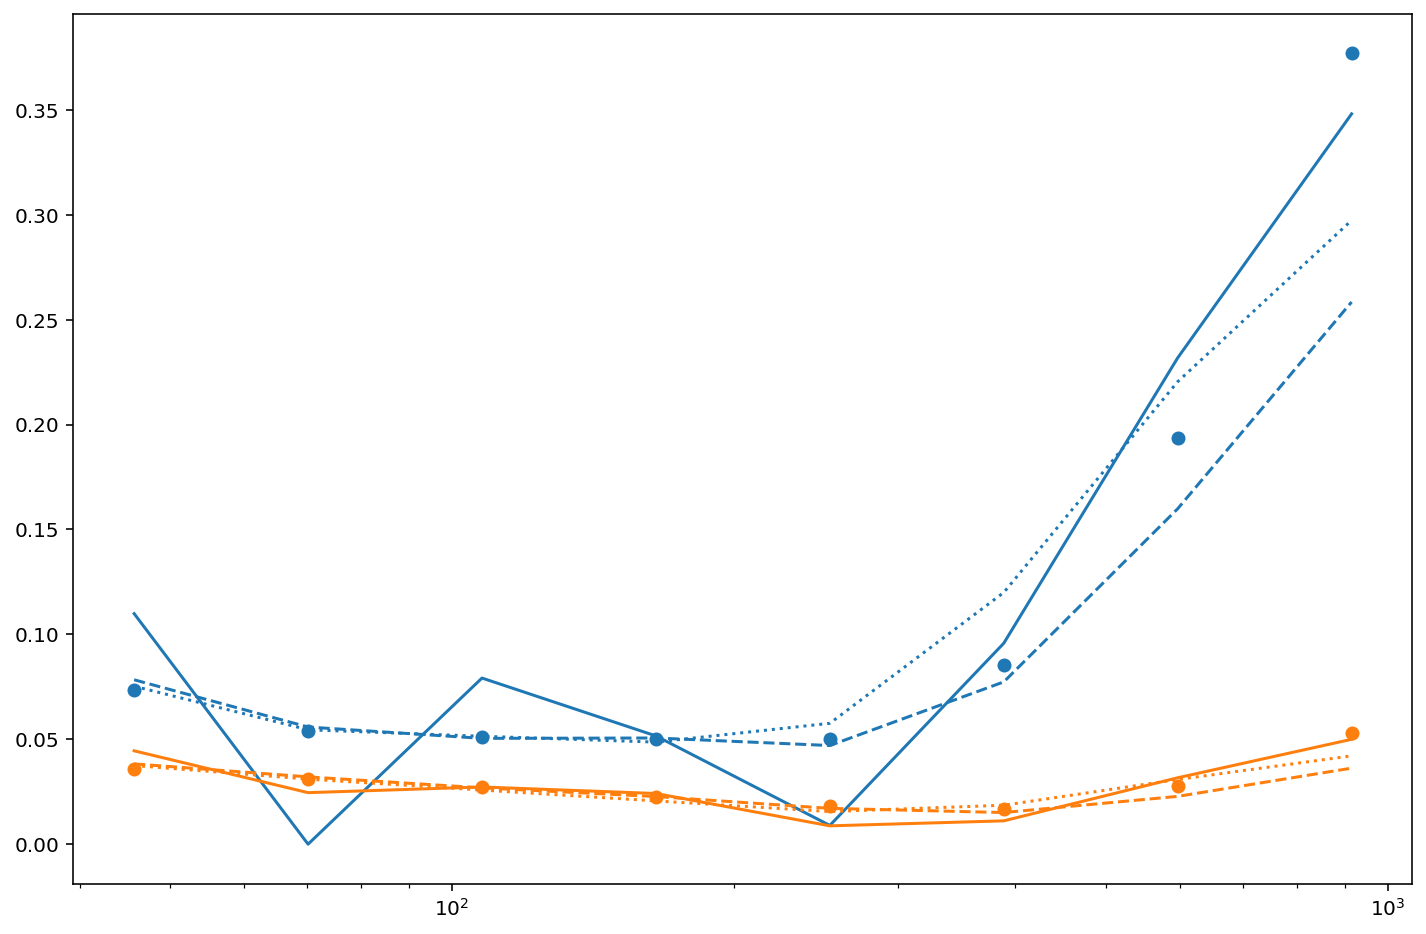

In [225]:
el = Optimizerkk.ells_selected
for i in range(2):
    b = abs(Optimizerkk.biases_selected[i, i])
    k = Optimizerkk.theory_selected
    
    p = plt.plot(el, b/k)
    
    plt.plot(el, gaussian_filter1d(b, 1)/gaussian_filter1d(k, 1), color = p[0].get_color(), ls = '--')
    
    b = abs(Optimizerkk.biases_selected[i, i])/k
    plt.plot(el, gaussian_filter1d(b, 1), color = p[0].get_color(), ls = ':')
    
    b = abs(Optimizerkk.biases_selected[i, i])
    plt.plot(el, gaussian_filter1d(b, 1)/k, color = p[0].get_color(), marker = 'o', ls = '')
    
plt.xscale('log')

In [226]:
#loss = (fractional noise)^2 + (fractional bias)^2 + (uncertainty on the fractional bias)^2,
#where the last term could basically be (0.01)^2. This way, even if an estimator has a bias=0, it counts just like a bias bias=1%. 

In [227]:
optversion = {'weights_name': 'absbias', 'sum_biases_squared': False, 'abs_biases': True, 'bias_squared': False,
                      'color': 'purple', 'latexformula': '\sigma^2(\hat{A}_{\rm{comb}})+\left(\int_{\vec{L}}\vec{a}^TB\vec{a}\right)^2'}

In [228]:
regularised = False

In [229]:
weights.shape

(8, 2)

In [230]:
bnds = [(-1e-6, 1)]*18

In [231]:
Nrolled = np.rollaxis(Optimizerkk.noises_selected, -1)
Ne = Optimizerkk.noises_selected.shape[0]
e = np.ones(Ne)
weights = np.linalg.inv(Nrolled).dot(e)
weights /= weights.dot(e.T)[:, None]

In [232]:
combinedtheta = Optimizerkk.get_variance_part(weights, Optimizerkk.theta_selected)

In [233]:
weights_l = Optimizerkk.get_mv_weights(Optimizerkk.ells_selected, Optimizerkk.theory_selected, combinedtheta)

In [234]:
weights_l.shape

(8,)

In [235]:
def get_mv_solution(self):
    Nrolled = np.rollaxis(self.noises_selected, -1)
    Ne = self.noises_selected.shape[0]
    e = np.ones(Ne)
    weights = np.linalg.inv(Nrolled).dot(e)
    weights /= weights.dot(e.T)[:, None]
    combinedtheta = Optimizerkk.get_variance_part(weights, self.theta_selected)
    weights_l = self.get_mv_weights(self.ells_selected, self.theory_selected, combinedtheta)
    return weights, weights_l

In [236]:
result.ws

(array([0.99433091, 0.99946944, 0.99953566, 0.9980437 , 0.99962481,
        0.9996557 , 0.99965716, 0.99957116]),
 array([0.00566909, 0.00053056, 0.00046434, 0.0019563 , 0.00037519,
        0.0003443 , 0.00034284, 0.00042884]),
 array([1.25190946e-05, 1.14569312e-05, 9.33549545e-06, 6.84812867e-06,
        3.58588077e-06, 1.64924893e-06, 6.13934617e-07, 2.06124358e-07]))

In [150]:
regularised = False
result = Optimizerkk.optimize(optversion, x0 = None, method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = 0., inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, strategy = 'Best1Bin', ftol = 1e-9)

#regularised = True
#result2 = Optimizerkk.optimize(optversion, method = 'diff-ev', x0 = result.x[:-Optimizerkk.nbins], bs0 = result.x[-Optimizerkk.nbins:], gtol = 500 ,bounds = [0, 1]
#                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'extra')

Start optimization with diff-ev
Doing for absbias
LEN 24
Generation 0 has ChiSquare: 0.000136
Generation 100 has ChiSquare: 0.000073
Generation 200 has ChiSquare: 0.000046
Generation 300 has ChiSquare: 0.000045
Generation 400 has ChiSquare: 0.000045
Generation 500 has ChiSquare: 0.000045
Generation 600 has ChiSquare: 0.000044
Generation 700 has ChiSquare: 0.000044
Generation 800 has ChiSquare: 0.000044
Generation 900 has ChiSquare: 0.000044
Generation 1000 has ChiSquare: 0.000044
Generation 1100 has ChiSquare: 0.000044
Generation 1200 has ChiSquare: 0.000044
Generation 1300 has ChiSquare: 0.000044
Generation 1400 has ChiSquare: 0.000044
Generation 1500 has ChiSquare: 0.000044
STOP("ChangeOverGeneration with {'tolerance': 1e-09, 'generations': 500}")
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 1502
         Function evaluations: 114203
Weights in columns [[9.94330913e-01 5.66908727e-03]
 [9.99469438e-01 5.30562324e-04]
 [9.9953566

In [237]:
regularised = True
result_second = Optimizerkk_.optimize(optversion, x0 = result.x[:-Optimizerkk.nbins], bs0 = result.x[-Optimizerkk.nbins:], method = 'diff-ev', gtol = 500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = 1., inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, strategy = 'Best1Bin', ftol = 1e-11)
regularised = False

Start optimization with diff-ev
Doing for absbias
Regularizing
LEN 24
Generation 0 has ChiSquare: 70469845848.796875
Generation 100 has ChiSquare: 70469845848.796875
Generation 200 has ChiSquare: 70469845848.796875
Generation 300 has ChiSquare: 19620843320.963413
Generation 400 has ChiSquare: 18424478452.700336
Generation 500 has ChiSquare: 7339333226.916437
Generation 600 has ChiSquare: 4671694982.822599
Generation 700 has ChiSquare: 3244021833.023842
Generation 800 has ChiSquare: 3124917929.411759
Generation 900 has ChiSquare: 2983742614.486395
Generation 1000 has ChiSquare: 2951108519.008549
Generation 1100 has ChiSquare: 2907903714.993870
Generation 1200 has ChiSquare: 2571151397.751222
Generation 1300 has ChiSquare: 2548545674.484791
Generation 1400 has ChiSquare: 2536199188.052106
Generation 1500 has ChiSquare: 2532528820.632680
Generation 1600 has ChiSquare: 2529363703.217792
Generation 1700 has ChiSquare: 2529363703.217792
Generation 1800 has ChiSquare: 2529363703.217792
Genera

In [152]:
result_third = Optimizerkk.optimize(optversion, x0 = result.x[:-Optimizerkk.nbins], bs0 = result.x[-Optimizerkk.nbins:], method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, strategy = 'Best1Bin', ftol = 1e-11)

Start optimization with diff-ev
Doing for absbias
LEN 24
Generation 0 has ChiSquare: 0.011279
Generation 100 has ChiSquare: 0.011279
Generation 200 has ChiSquare: 0.011279
Generation 300 has ChiSquare: 0.011279
Generation 400 has ChiSquare: 0.011279
Generation 500 has ChiSquare: 0.011279
Generation 600 has ChiSquare: 0.011272
Generation 700 has ChiSquare: 0.003887
Generation 800 has ChiSquare: 0.001439
Generation 900 has ChiSquare: 0.000485
Generation 1000 has ChiSquare: 0.000479
Generation 1100 has ChiSquare: 0.000474
Generation 1200 has ChiSquare: 0.000472
Generation 1300 has ChiSquare: 0.000471
Generation 1400 has ChiSquare: 0.000471
Generation 1500 has ChiSquare: 0.000443
Generation 1600 has ChiSquare: 0.000443
Generation 1700 has ChiSquare: 0.000443
Generation 1800 has ChiSquare: 0.000443
Generation 1900 has ChiSquare: 0.000443
Generation 2000 has ChiSquare: 0.000443
Generation 2100 has ChiSquare: 0.000443
Generation 2200 has ChiSquare: 0.000443
Generation 2300 has ChiSquare: 0.00

In [153]:
result_fourth = Optimizerkk.optimize(optversion, x0 = result.x[:-Optimizerkk.nbins], bs0 = result.x[-Optimizerkk.nbins:], method = 'diff-ev', gtol = 1500 ,bounds = [0, 1]
                              ,noisebiasconstr = noisebiasconstr, fb = fb, inv_variance = invvariance, regularise = regularised, regtype = 'biaserror',
                              scale = 0.8, cross = 0.9, npopfactor = 1, strategy = 'Best1Bin', ftol = 1e-11)

Start optimization with diff-ev
Doing for absbias
LEN 24
Generation 0 has ChiSquare: 0.011279
Generation 100 has ChiSquare: 0.011279
Generation 200 has ChiSquare: 0.011279
Generation 300 has ChiSquare: 0.011260
Generation 400 has ChiSquare: 0.011260
Generation 500 has ChiSquare: 0.011260
Generation 600 has ChiSquare: 0.009352
Generation 700 has ChiSquare: 0.000546
Generation 800 has ChiSquare: 0.000454
Generation 900 has ChiSquare: 0.000424
Generation 1000 has ChiSquare: 0.000424
Generation 1100 has ChiSquare: 0.000349
Generation 1200 has ChiSquare: 0.000241
Generation 1300 has ChiSquare: 0.000217
Generation 1400 has ChiSquare: 0.000216
Generation 1500 has ChiSquare: 0.000194
Generation 1600 has ChiSquare: 0.000187
Generation 1700 has ChiSquare: 0.000181
Generation 1800 has ChiSquare: 0.000176
Generation 1900 has ChiSquare: 0.000176
Generation 2000 has ChiSquare: 0.000175
Generation 2100 has ChiSquare: 0.000172
Generation 2200 has ChiSquare: 0.000172
Generation 2300 has ChiSquare: 0.00

In [154]:
f, n, b = fnb_getter(Optimizerkk, 1., False)

In [155]:
result_third.x

array([1.75419714e-01, 8.24580286e-01, 1.00000000e+00, 8.08778600e-11,
       1.09543076e-01, 8.90456924e-01, 1.35369049e-02, 9.86463095e-01,
       1.00000000e+00, 2.89818614e-10, 5.30671424e-02, 9.46932858e-01,
       1.47364113e-01, 8.52635887e-01, 2.05898733e-02, 9.79410127e-01,
       4.47331134e-14, 4.40944484e-05, 1.47721052e-14, 6.67113453e-15,
       8.06905786e-06, 2.63350149e-06, 4.24139162e-16, 9.78793534e-17])

In [156]:
result_fourth.x

array([7.41035045e-01, 2.58964955e-01, 1.00000000e+00, 2.13937756e-11,
       2.59802931e-02, 9.74019707e-01, 2.82095473e-02, 9.71790453e-01,
       1.00000000e+00, 1.68054459e-12, 5.30685306e-02, 9.46931469e-01,
       8.92570059e-02, 9.10742994e-01, 4.36105034e-02, 9.56389497e-01,
       3.38368904e-15, 4.40942908e-05, 2.55084844e-15, 4.95319319e-15,
       8.06895772e-06, 2.63354918e-06, 1.12355320e-16, 1.15417084e-16])

In [157]:
result.ws

(array([0.99433091, 0.99946944, 0.99953566, 0.9980437 , 0.99962481,
        0.9996557 , 0.99965716, 0.99957116]),
 array([0.00566909, 0.00053056, 0.00046434, 0.0019563 , 0.00037519,
        0.0003443 , 0.00034284, 0.00042884]),
 array([1.25190946e-05, 1.14569312e-05, 9.33549545e-06, 6.84812867e-06,
        3.58588077e-06, 1.64924893e-06, 6.13934617e-07, 2.06124358e-07]))

In [158]:
result_second.ws

(array([2.76899376e-11, 1.00000000e+00, 1.24719716e-11, 5.95372613e-12,
        1.00000000e+00, 4.80808124e-02, 1.50270188e-12, 8.17601488e-13]),
 array([1.00000000e+00, 1.74460446e-12, 1.00000000e+00, 1.00000000e+00,
        1.12364562e-11, 9.51919188e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.25190946e-05, 1.14569312e-05, 9.33549545e-06, 6.84812867e-06,
        3.58588077e-06, 1.64924893e-06, 6.13934617e-07, 2.06124358e-07]))

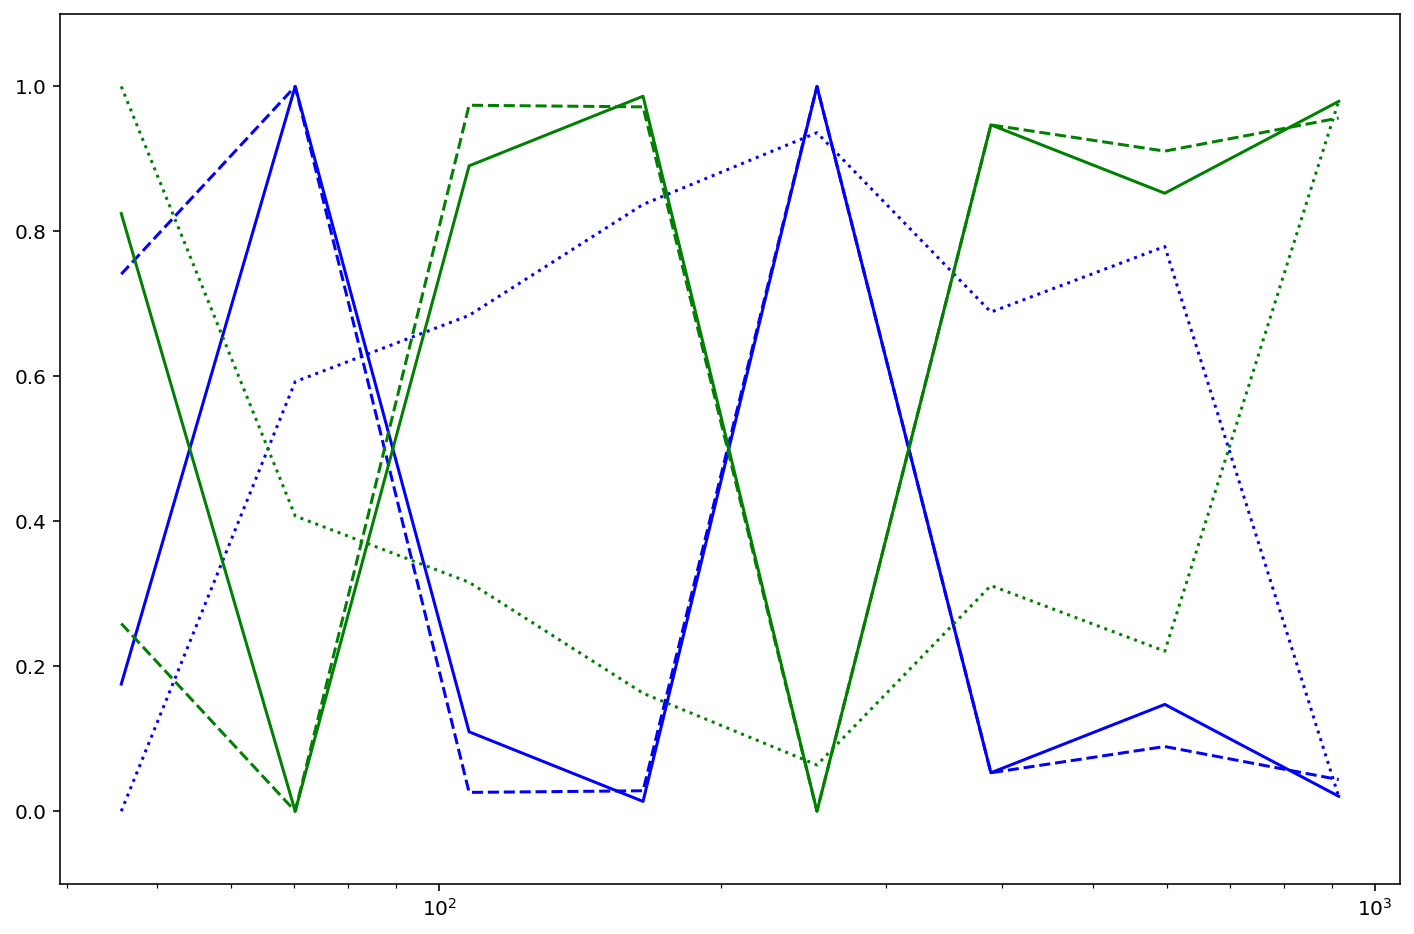

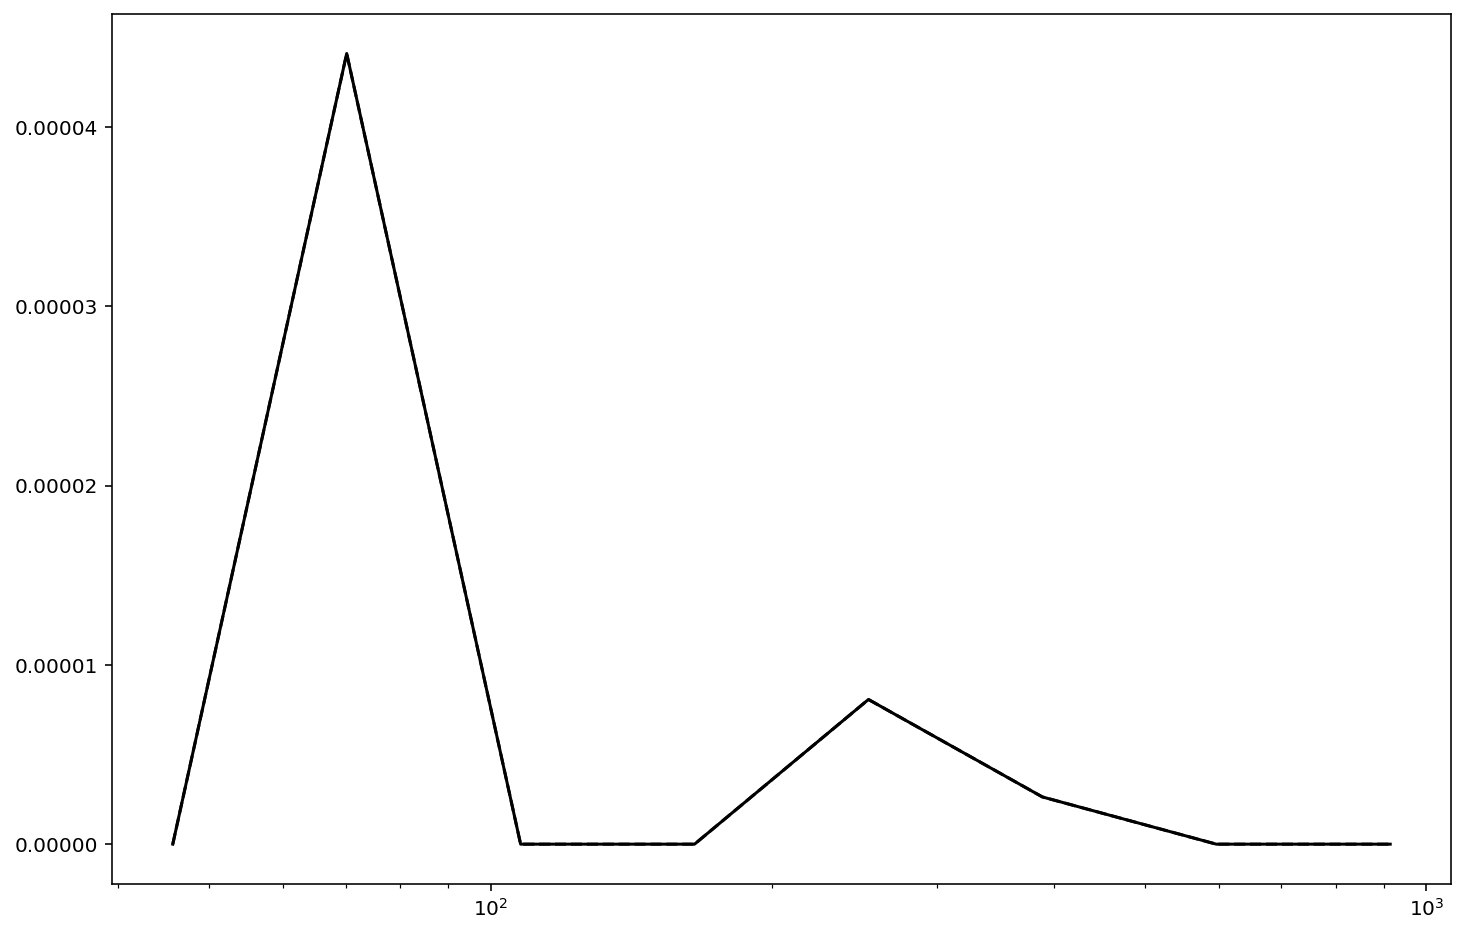

In [238]:
def plot_ris(ris, index, color, ls):
    plt.plot(ris.ells, ris.ws[index], color = color, ls = ls)
    
index = 0
plot_ris(result_second, index, color = 'blue', ls = ':')
plot_ris(result_third, index, color = 'blue', ls = '-')
plot_ris(result_fourth, index, color = 'blue', ls = '--')

plt.ylim(-0.1, 1.1)

index = 1
plot_ris(result_second, index, color = 'green', ls = ':')
plot_ris(result_third, index, color = 'green', ls = '-')
plot_ris(result_fourth, index, color = 'green', ls = '--')

plt.xscale('log')
plt.show()


plot_ris(result_third, -1, color = 'black', ls = '-')
plot_ris(result_fourth, -1, color = 'black', ls = '--')
plt.xscale('log')
plt.show()

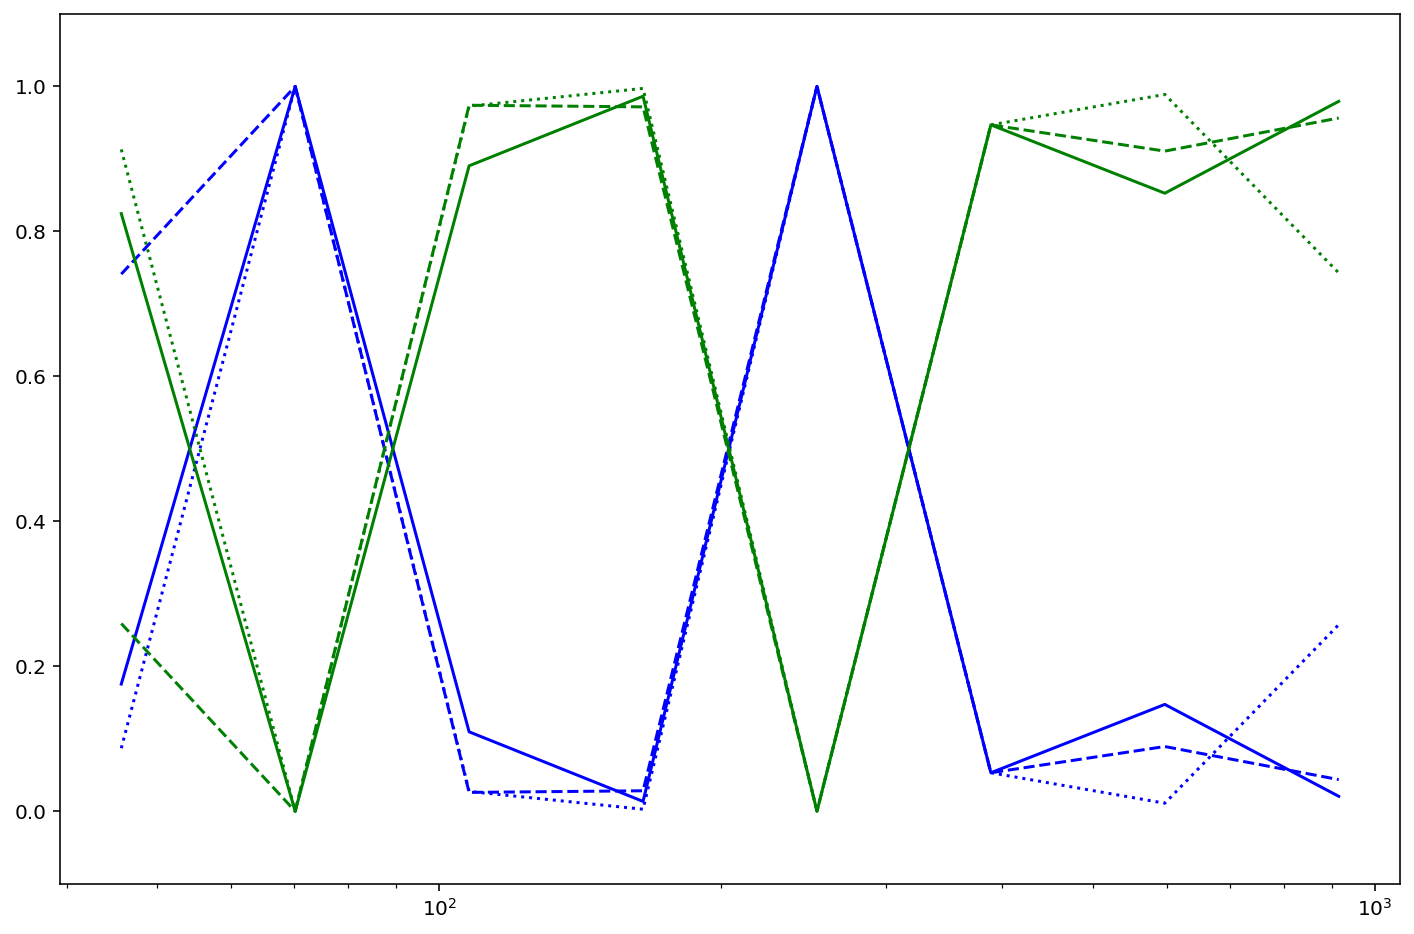

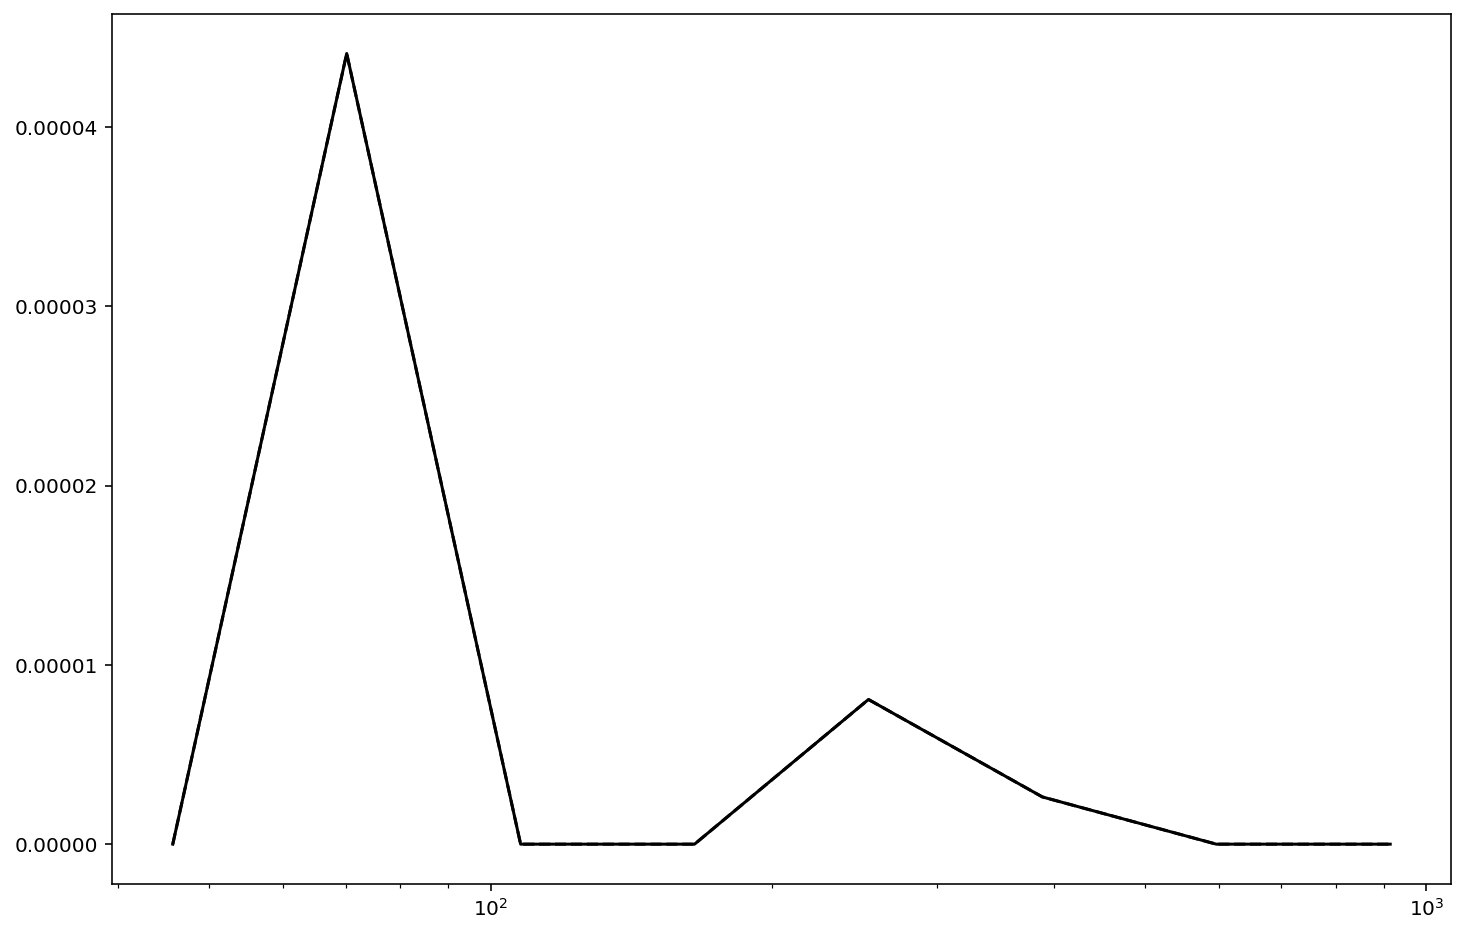

In [202]:
def plot_ris(ris, index, color, ls):
    plt.plot(ris.ells, ris.ws[index], color = color, ls = ls)
    
index = 0
plot_ris(result_second, index, color = 'blue', ls = ':')
plot_ris(result_third, index, color = 'blue', ls = '-')
plot_ris(result_fourth, index, color = 'blue', ls = '--')

plt.ylim(-0.1, 1.1)

index = 1
plot_ris(result_second, index, color = 'green', ls = ':')
plot_ris(result_third, index, color = 'green', ls = '-')
plot_ris(result_fourth, index, color = 'green', ls = '--')

plt.xscale('log')
plt.show()


plot_ris(result_third, -1, color = 'black', ls = '-')
plot_ris(result_fourth, -1, color = 'black', ls = '--')
plt.xscale('log')
plt.show()

In [160]:
xx = result.x

xx0 = xx.copy()
temp = xx0[1]
xx0[1] = xx0[0]
xx0[0] = temp

print(f(xx))
print(n(xx))
print(f(xx)/f(xx0))

0.005055230954580747
0.00665421791777091
0.9751339719932259


In [161]:
abs(f(result_third.x))/f(result_fourth.x)

0.9999999983049704

In [162]:
abs(f(result_third.x)-f(result_fourth.x))/f(result_fourth.x)

1.6950295766661975e-09

In [163]:
abs(f(result.x)-f(result_second.x))/f(result_second.x)
0.0002946859641587198

0.0002946859641587198

In [164]:
xx = result_second.x
print(f(xx))
print(n(xx))

8.697004301700599e-05
0.007042348282174662


In [165]:
font = font_manager.FontProperties(family = 'cmss10',
                                   style = 'normal', size = 15)

In [166]:
def loop_over(v):
    selection = np.ones_like(v, dtype = bool)
    result = 0.
    for i, vx in enumerate(v):
        selectiontemp = selection
        selectiontemp[i] = False
        result += np.sum((1-selectiontemp*v)**2.)*vx**2.
    return result

[False  True False False False False False False]
[0.10986831 0.         0.07916715 0.05158962 0.00893256 0.09575348
 0.2317681  0.3480609 ]
[False False False False False False False False]
[0.04449263 0.02454783 0.02725862 0.02414918 0.00872754 0.01111363
 0.03164347 0.04996886]
[0.28248699 0.25868368 0.21083699 0.15464837 0.08098376 0.03725787
 0.01386367 0.00465488]
[0.27198841 0.24746757 0.19859196 0.14175987 0.07032545 0.03090388
 0.01124796 0.00382453]


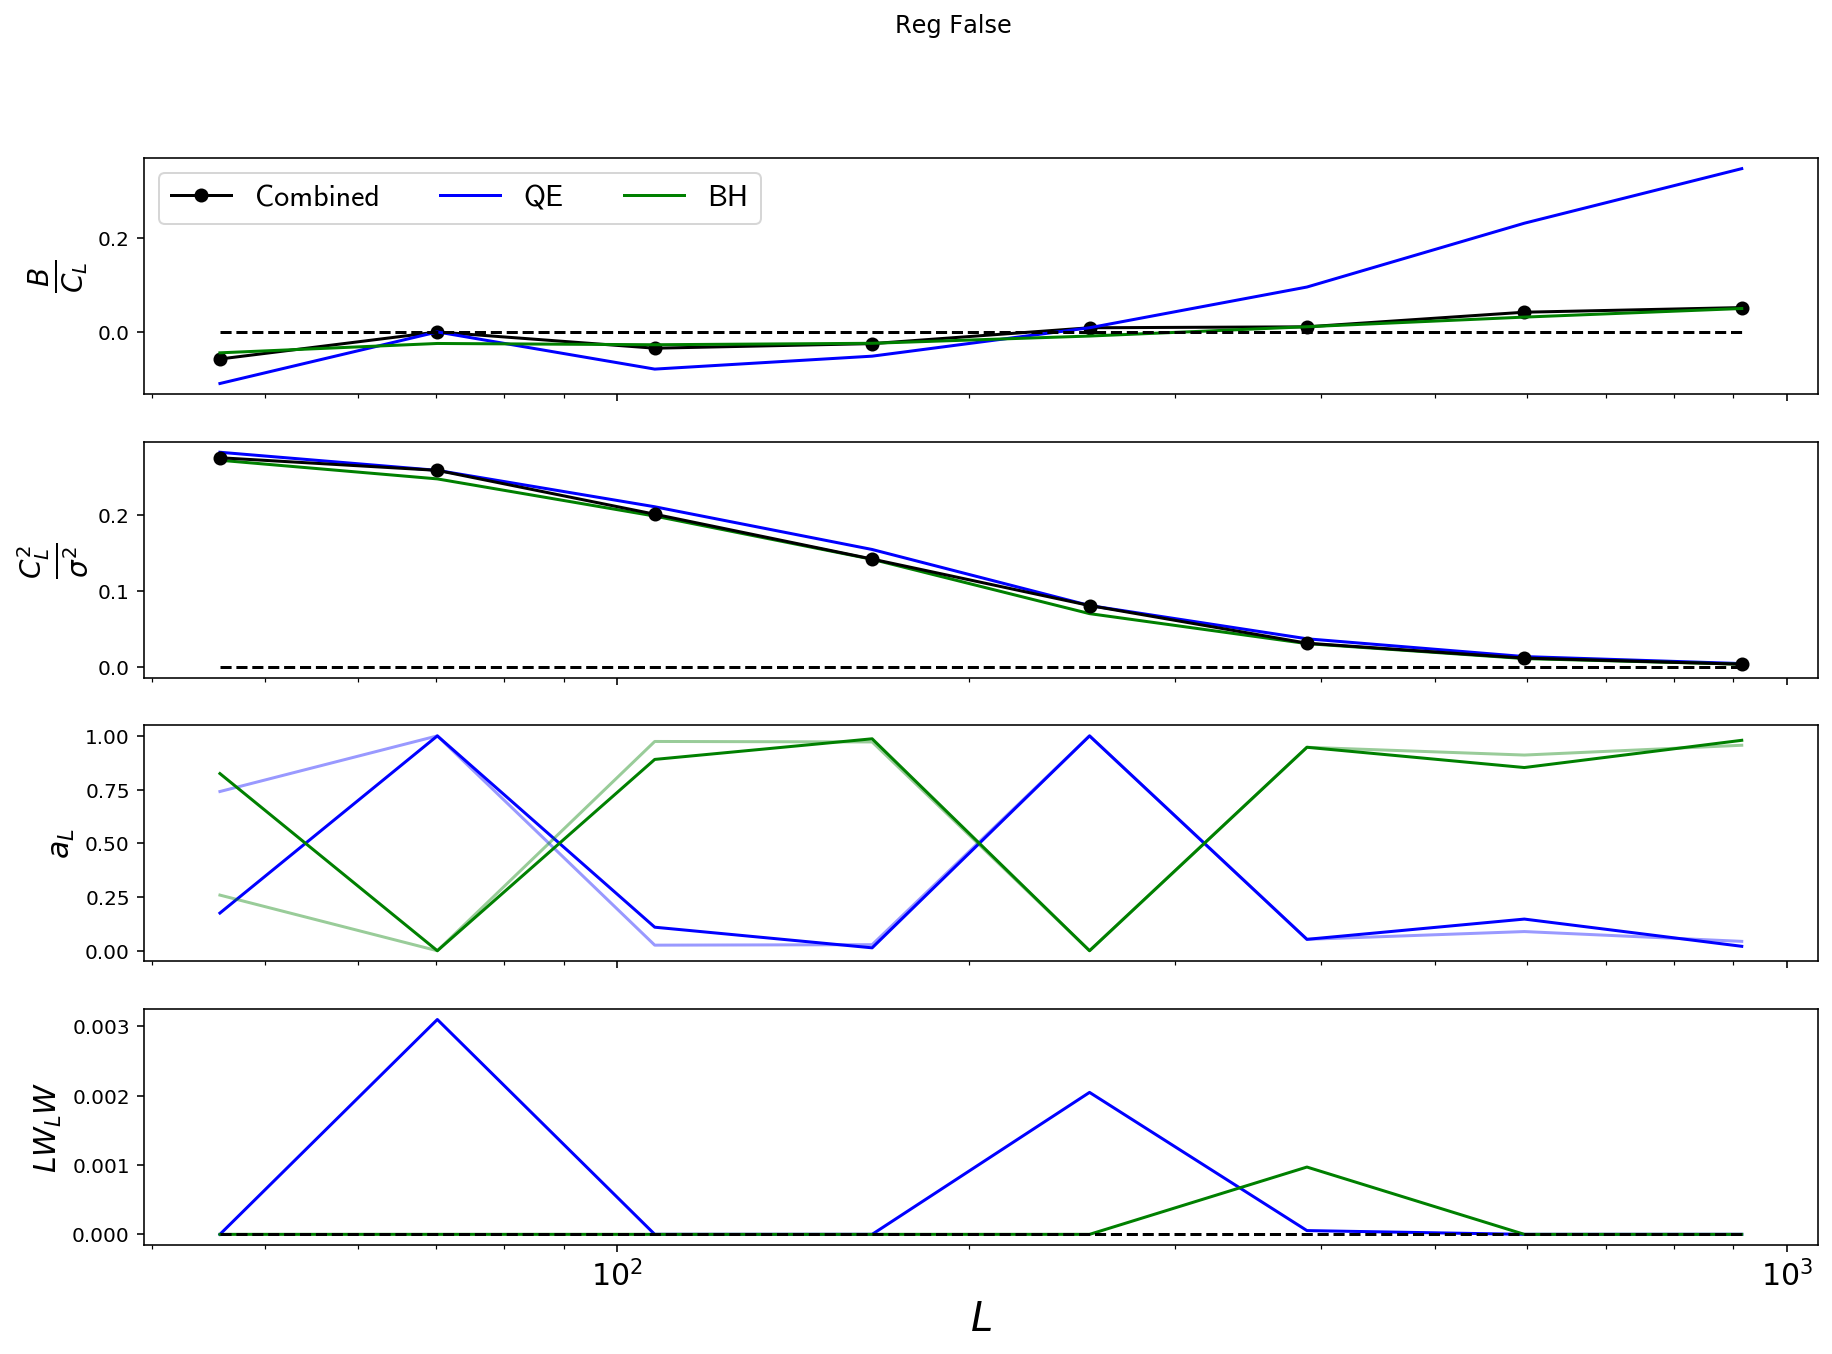

In [239]:
w = result_third.ws
w2 = result_fourth.ws

Nestimators = len(Optimizerkk.estimators)
Ne = Nestimators
a = np.c_[w[:2]]
a2 = np.c_[w2[:2]]
wl = w[-1]
combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

ells = Optimizerkk.ells_selected
kk = Optimizerkk.theory_selected
Ne = len(Optimizerkk.estimators)

names = ['QE', 'BH']
colors = ['blue', 'green']

fig, ax = plt.subplots(nrows = 4, sharex = True, figsize = (15, 10))
fig.suptitle(f'Reg {regularised}')
ax[0].plot(ells, combinedb/kk, color = 'black', label = 'Combined', marker = 'o')

for i in range(Ne):
    print(abs(Optimizerkk.biases_selected[i, i]/kk)<0.001)
    print(abs(Optimizerkk.biases_selected[i, i]/kk))
    ax[0].plot(ells, Optimizerkk.biases_selected[i, i]/kk, color = colors[i], label = names[i])
ax[0].plot(ells, ells*0, color = 'black', ls = '--')
ax[0].legend(loc = 'best', ncol = len(names)+1, prop = font)


for i in range(Ne):
    print((Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1.)
    ax[1].plot(ells, (Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1., color = colors[i])

ax[1].plot(ells, (combinedtheta/kk**2)**-1., color = 'black', marker = 'o')
ax[1].plot(ells, ells*0, color = 'black', ls = '--')


        

for i in range(Ne):
    ax[2].plot(ells, w[i], color = colors[i])
    ax[2].plot(ells, w2[i], color = colors[i], alpha = 0.4)
    ax[-1].plot(ells, w[i]*wl*ells, color = colors[i])

#ax[-1].plot(ells, wl, color = 'black')
ax[-1].plot(ells, ells*0., color = 'black', ls = '--')

ax[0].set_ylabel('$\\frac{B}{C_L}$', size = 20)
ax[1].set_ylabel('$\\frac{C_L^2}{\sigma^2}$', size = 20)
ax[2].set_ylabel('$a_L$', size = 15)
ax[-1].set_ylabel('$LW_LW$', size = 15)

ax[0].set_xscale('log')
ax[-1].set_xlabel('$L$', size = 20)

ax[-1].tick_params(axis = 'x', which='major', labelsize = 15)

fig.savefig(paperplots/f'example_section2_4000.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [320]:
f, n, b = fnb_getter(Optimizerkk, 1., False)

In [321]:
wl = w[-1]

array([6.97496045e-15, 4.53907424e-05, 6.45700705e-15, 1.20363597e-14,
       7.52689869e-06, 2.82161126e-06, 1.46938027e-16, 2.80730116e-17,
       1.13191102e-17, 1.26616596e-17, 3.05832590e-18])

In [39]:
f(result.x)

0.00012340195765160917

In [40]:
n(result.x)

0.011097574658098436

In [41]:
b(result.x)

0.000495776521772217

In [128]:
x_est = get_est_weights(Optimizerkk, 0)
f_, n_, b_ = fnb_getter(Optimizerkk, 1., True)

In [129]:
f_(x_est)

0.004599248309826383

In [130]:
n_(x_est)

0.00665421745405974

In [131]:
b_(x_est)

0.06749051562923837

In [132]:
abs(n_(x_est)-n(result.x))/n(result.x)

0.4003901765327202

In [65]:
direc = pathlib.Path('output_ILC_1503/b4000sybh3000p4500sy3000/total/')

In [66]:
bias = np.load(direc/'totalbias_total_ilc.npy')
kk = np.load(direc/'kk_total_ilc.npy')
scatterbias = np.load(direc/'scatter_totalbias_ilc.npy')
ells = np.load(direc/'ells_total_ilc.npy')

In [69]:
selection = (ells>30) & (ells<1200)

In [72]:
deltay/y*100

array([-30.43637444, -50.16244546, -26.29938935, -24.69618827,
       -88.06265722, 100.61327062,  54.43002202,  45.12664924])

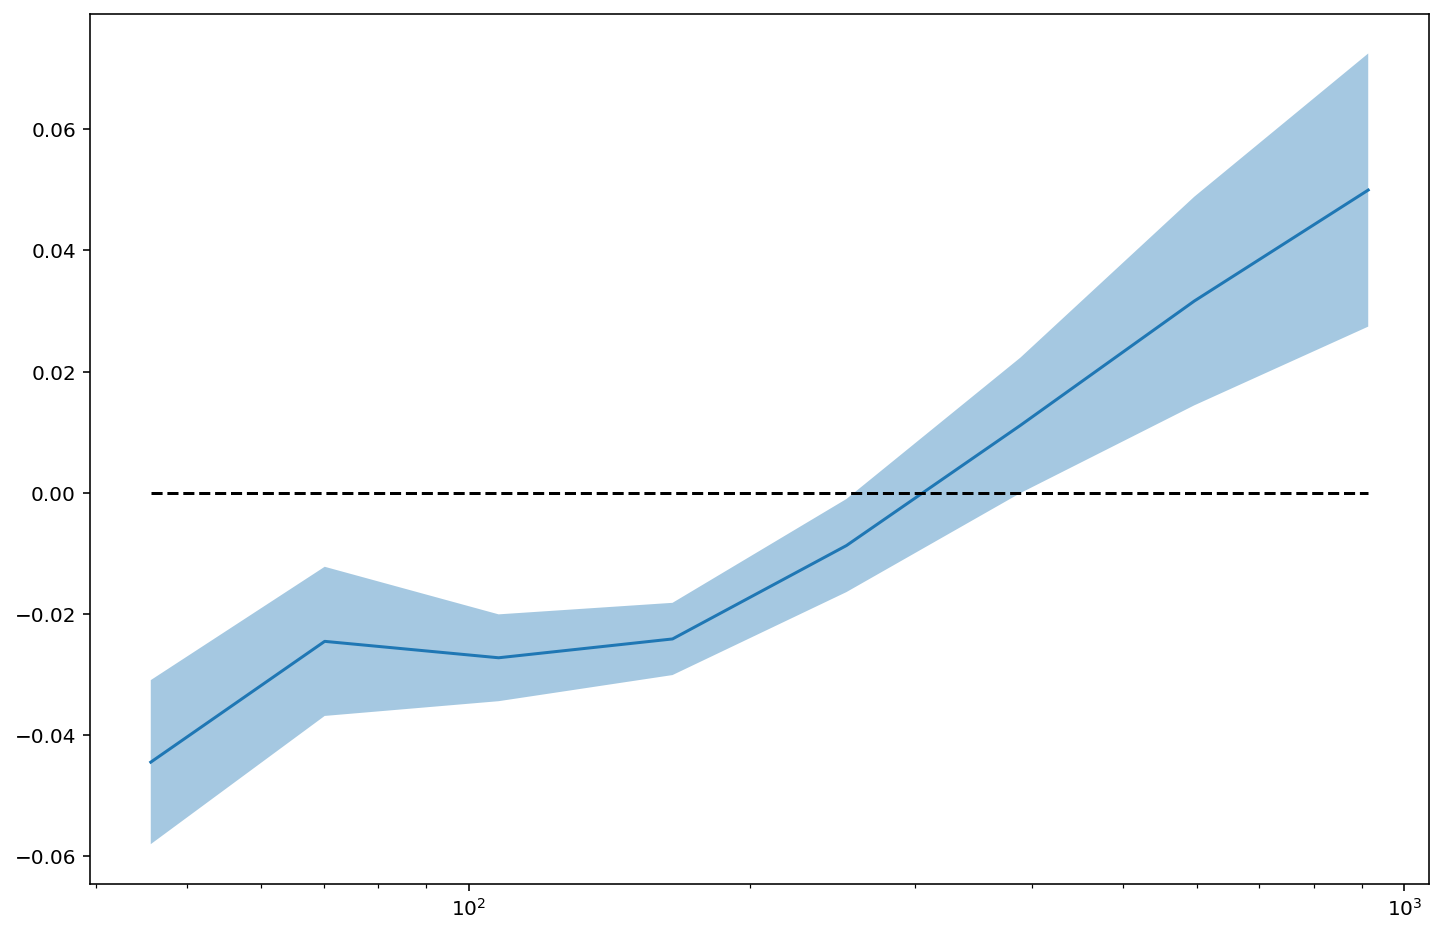

In [70]:
i = 0
y = (bias[i, i]/kk)[selection]
ellsplot = ells[selection]
deltay = (scatterbias[i, i]/kk)[selection]
plt.fill_between(ellsplot, y-deltay, y+deltay, alpha = 0.4)
plt.plot(ellsplot, y)
plt.plot(ellsplot, y*0., color = 'black', ls = '--')

plt.xscale('log')

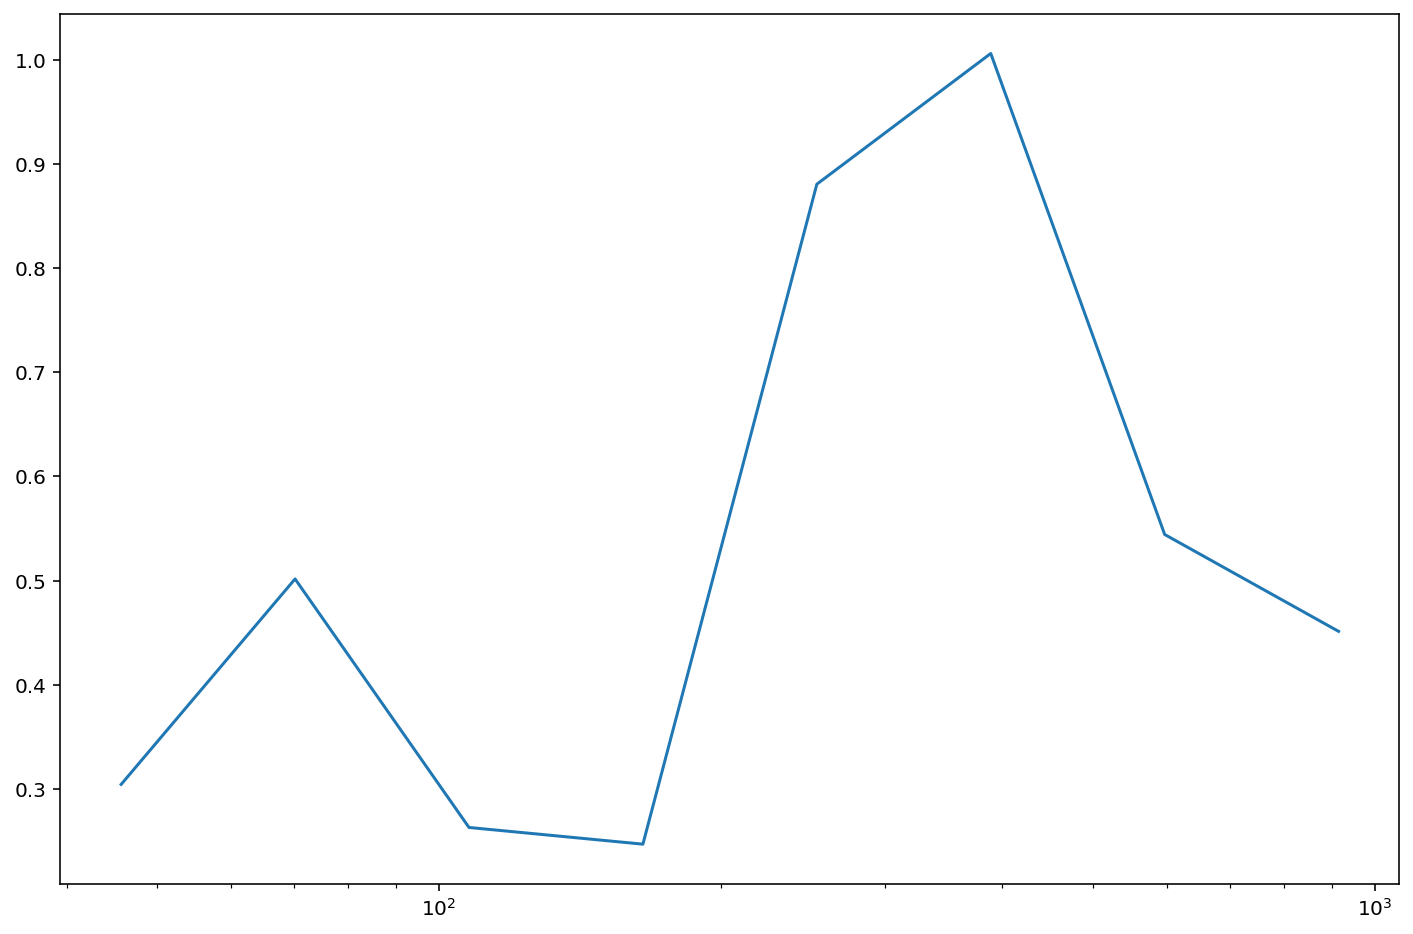

In [75]:
frac = abs(scatterbias[i, i]/bias[i, i])[selection]
plt.plot(ellsplot, frac)
plt.xscale('log')

In [51]:
from mystic.models import rosen

In [132]:
from mystic.solvers import fmin
from mystic.solvers import diffev, sparsity, buckshot, lattice

In [133]:
x0 = np.ones(5)

In [134]:
x0 = [0.8,1.2,0.7]
rosen(x0)

86.19999999999997

In [135]:
x0 = np.random.randn(20)

In [141]:
for i in range(10):
    solution = diffev(rosen,x0, maxiter = 1024**3, maxfun = 1024**3, gtol = 300, npop = 10*len(x0), scale = 0.9, mon = VerboseMonitor(100), ftol = 1e-6)
    print(solution)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4245
         Function evaluations: 849200
[1.0000069  1.00000395 0.99999599 1.00000309 0.99999203 0.99999859
 1.00000789 0.99999325 0.99999736 0.99999731 0.99998803 0.99999834
 0.99999239 1.00001058 1.00000386 0.9999969  0.99997542 0.99996772
 0.99993422 0.99985499]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4129
         Function evaluations: 826000
[1.00000668 0.99999563 0.99999401 0.99999537 1.00000434 1.00000111
 1.00000753 1.0000104  1.00001252 1.00000129 1.00000785 1.00000706
 1.00000745 0.99999979 0.9999958  0.99999646 0.99998936 0.99995844
 0.99991551 0.99985478]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4425
         Function evaluations: 885200
[0.99998941 1.000007   1.00000406 0.99999043 0.99999463 0.99999187
 1.00001101 0.99999965 1.00001287 1.00001922 0.9999

KeyboardInterrupt: 

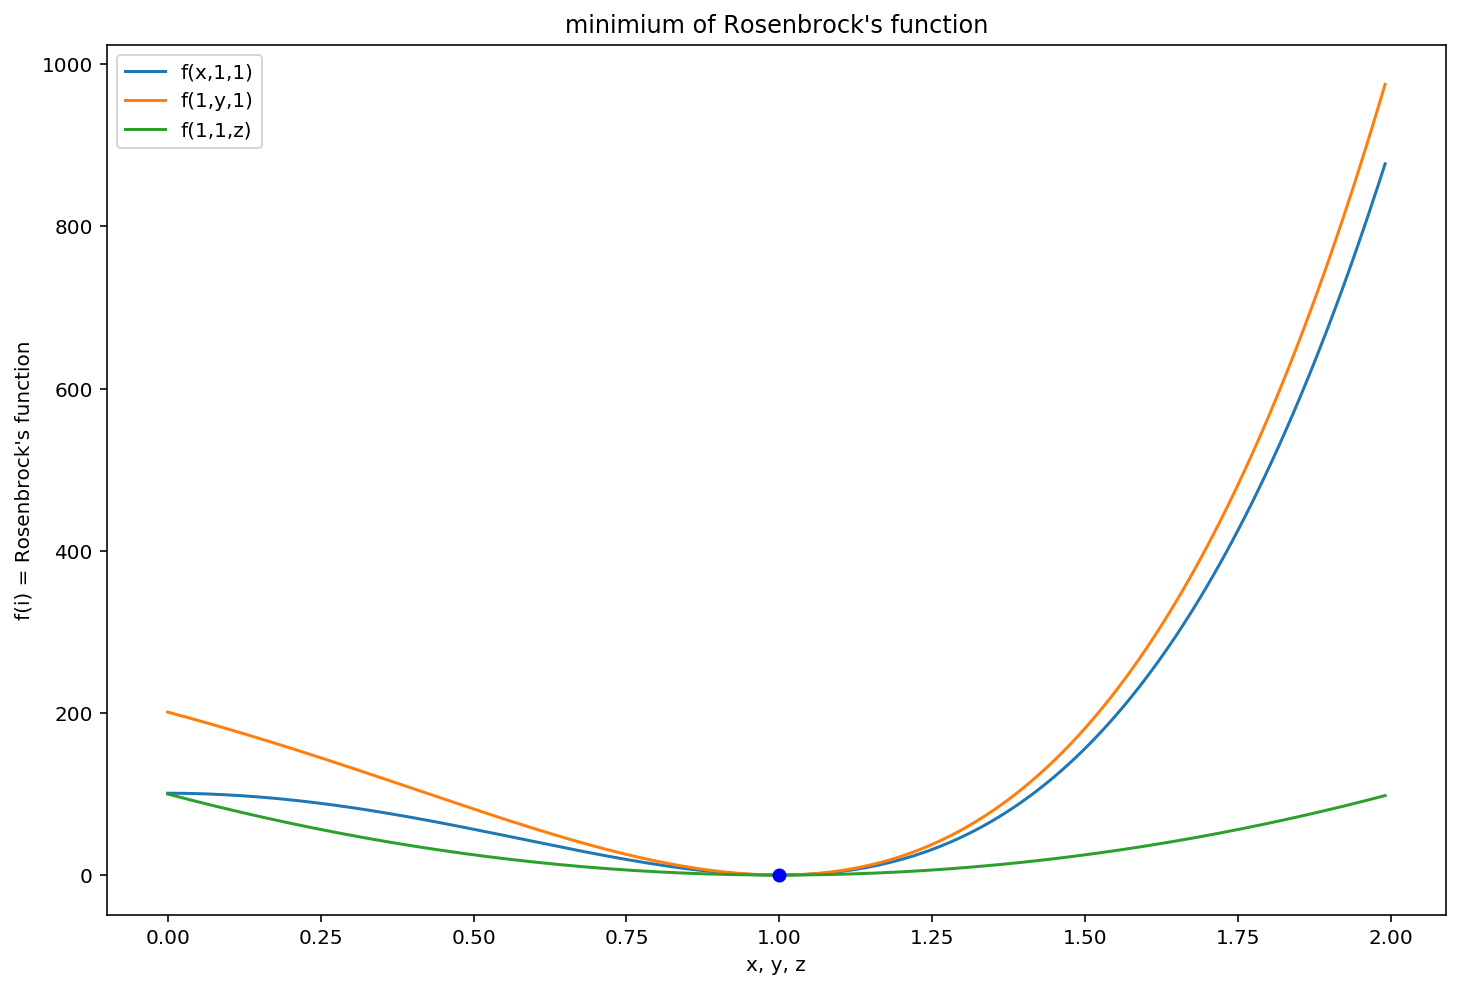

In [57]:
x = [0.01*i for i in range(200)]
plt.plot(x,[rosen([i,1.,1.]) for i in x])
plt.plot(x,[rosen([1.,i,1.]) for i in x])
plt.plot(x,[rosen([1.,1.,i]) for i in x])
# plot the solved minimum (for x)
plt.plot([solution[0]],[rosen(solution)],'bo')

# draw the plot
plt.title("minimium of Rosenbrock's function")
plt.xlabel("x, y, z")
plt.ylabel("f(i) = Rosenbrock's function")
plt.legend(["f(x,1,1)","f(1,y,1)","f(1,1,z)"])
plt.show()